In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from lightweight_clustered_energy_forecasts.utils.paths import data_dir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [37]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [38]:
building_11a.index.freq="15T"

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_21596\161432725.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  building_11a.index.freq="15T"


In [39]:
building_11a.head()

,kwh
timestamp,
2023-01-01 00:00:00+00:00,15.66
2023-01-01 00:15:00+00:00,15.39
2023-01-01 00:30:00+00:00,12.59
2023-01-01 00:45:00+00:00,11.26
2023-01-01 01:00:00+00:00,16.10


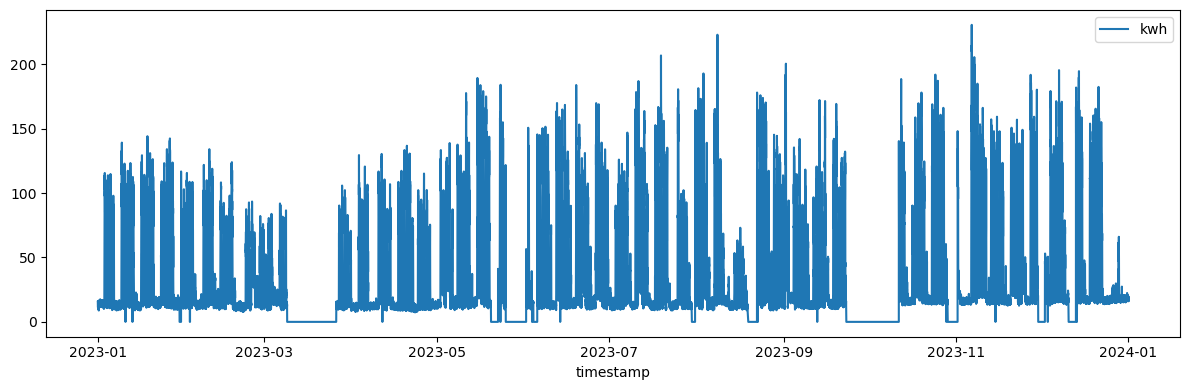

In [40]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [41]:
building_11a_hourly=building_11a.resample("h").sum()

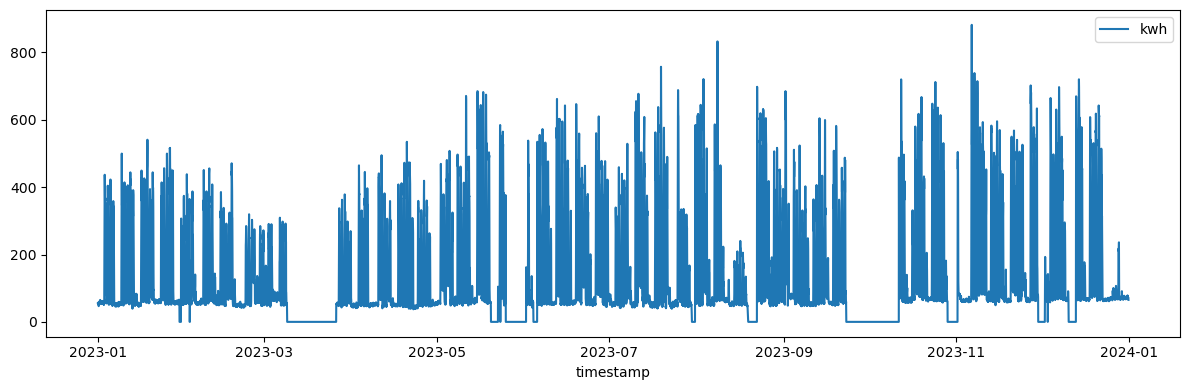

In [42]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a_hourly)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Time serie split 

In [43]:
train = building_11a_hourly.loc[building_11a_hourly.index < '2023-11-30']
test = building_11a_hourly.loc[building_11a_hourly.index >= '2023-11-30']

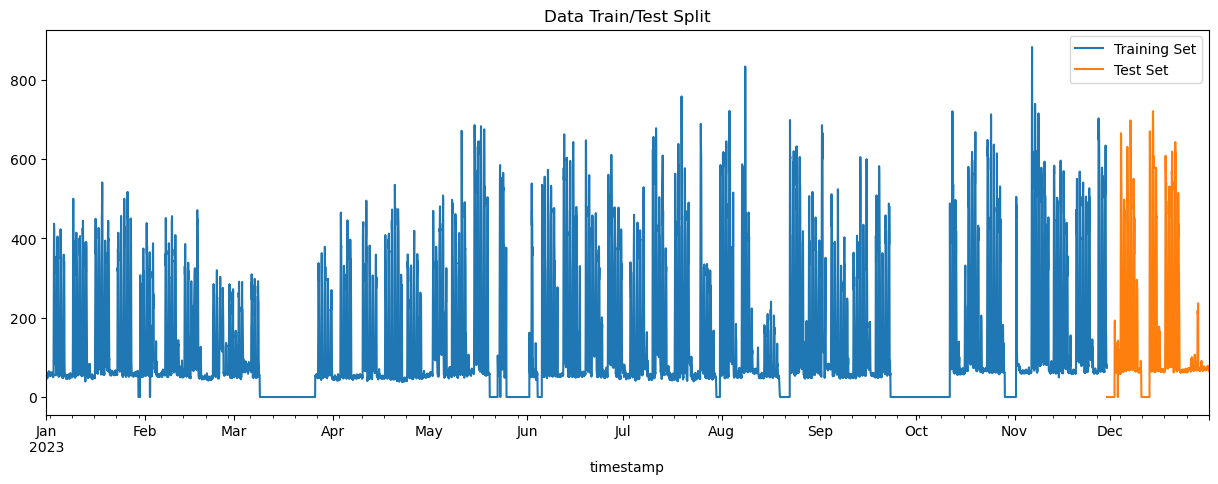

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


## time series cross validation

In [45]:
from sklearn.model_selection import TimeSeriesSplit

In [46]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24)
df = building_11a_hourly.sort_index()

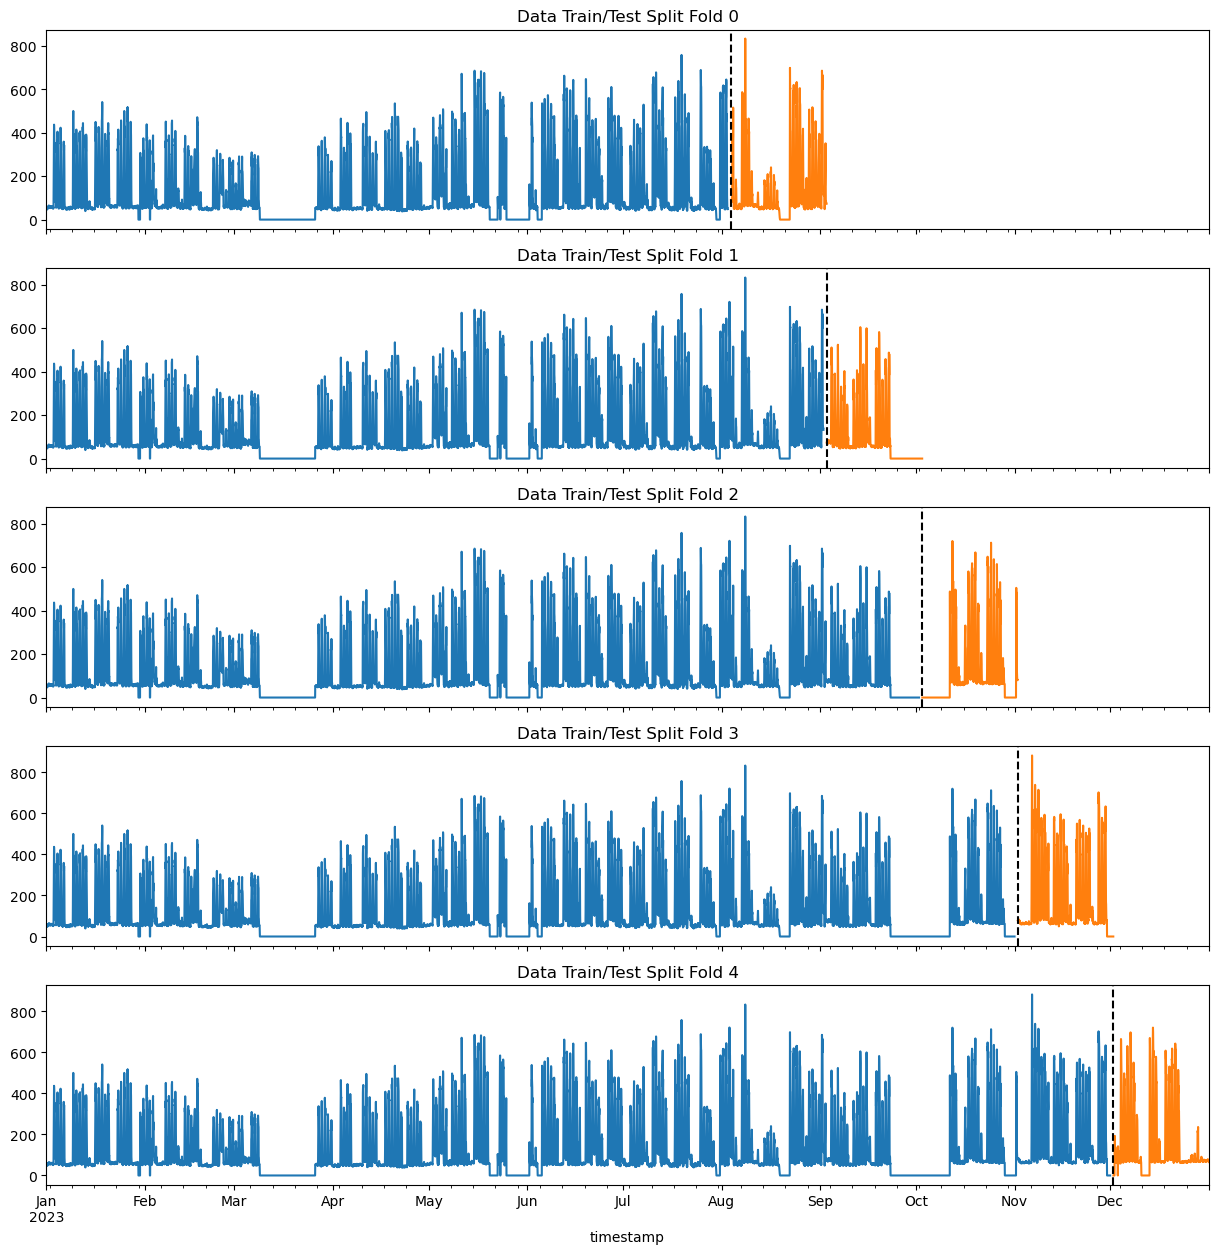

In [47]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['kwh'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['kwh'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Feature Extraction

In [48]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [49]:
df = create_features(df)
df.head()

,kwh,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,
2023-01-01 00:00:00+00:00,54.90,0,6,1,1,1,1,52
2023-01-01 01:00:00+00:00,53.81,1,6,1,1,1,1,52
2023-01-01 02:00:00+00:00,52.92,2,6,1,1,1,1,52
2023-01-01 03:00:00+00:00,55.99,3,6,1,1,1,1,52
2023-01-01 04:00:00+00:00,57.55,4,6,1,1,1,1,52


In [50]:
def add_lags(df):
    target_map = df['kwh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df

In [51]:
df = add_lags(df)
df

,kwh,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
timestamp,,,,,,,,,,,
2023-01-01 00:00:00+00:00,54.90,0,6,1,1,1,1,52,NaN,NaN,NaN
2023-01-01 01:00:00+00:00,53.81,1,6,1,1,1,1,52,NaN,NaN,NaN
2023-01-01 02:00:00+00:00,52.92,2,6,1,1,1,1,52,NaN,NaN,NaN
2023-01-01 03:00:00+00:00,55.99,3,6,1,1,1,1,52,NaN,NaN,NaN
2023-01-01 04:00:00+00:00,57.55,4,6,1,1,1,1,52,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00+00:00,70.52,19,6,4,12,365,31,52,69.19,66.90,0.0
2023-12-31 20:00:00+00:00,72.07,20,6,4,12,365,31,52,64.43,67.55,0.0
2023-12-31 21:00:00+00:00,72.65,21,6,4,12,365,31,52,65.88,61.38,0.0


## Training

In [52]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month',
                'lag1','lag2','lag3']
    TARGET = 'kwh'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:181.94753	validation_1-rmse:203.22537
[100]	validation_0-rmse:101.61312	validation_1-rmse:122.94556
[200]	validation_0-rmse:81.52031	validation_1-rmse:111.58813
[298]	validation_0-rmse:73.83120	validation_1-rmse:111.02053
[0]	validation_0-rmse:186.02215	validation_1-rmse:162.35904
[100]	validation_0-rmse:104.89838	validation_1-rmse:100.20389
[200]	validation_0-rmse:84.52054	validation_1-rmse:94.76450
[222]	validation_0-rmse:82.21554	validation_1-rmse:95.86014
[0]	validation_0-rmse:183.84378	validation_1-rmse:192.72576
[100]	validation_0-rmse:105.42149	validation_1-rmse:179.73561
[200]	validation_0-rmse:85.39252	validation_1-rmse:174.92460
[276]	validation_0-rmse:79.66178	validation_1-rmse:174.19997
[0]	validation_0-rmse:184.30534	validation_1-rmse:244.59190
[100]	validation_0-rmse:110.46978	validation_1-rmse:204.20528
[200]	validation_0-rmse:91.48877	validation_1-rmse:180.68748
[300]	validation_0-rmse:83.94290	validation_1-rmse:173.54137
[321]	validation_0-rmse:82

In [53]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 132.8108
Fold scores:[np.float64(110.74852131244101), np.float64(94.20443739964381), np.float64(173.42219153320335), np.float64(169.77645333375233), np.float64(115.90250385452474)]


## Predicting the future

In [58]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month',
            'lag1', 'lag2', 'lag3']
TARGET = 'kwh'

X_all = df[FEATURES]
y_all = df[TARGET]

# Entrenar el modelo
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)


In [59]:
reg.fit(X_all, y_all, verbose=100)


c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
df.index.max()

Timestamp('2023-12-31 23:00:00+0000', tz='UTC')

In [65]:
df.index.hour

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       ...
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype='int32', name='timestamp', length=8760)

In [70]:
# Create future dataframe
future = pd.date_range('2023-12-31','2024-01-31', freq='h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

In [92]:
future_df = create_features(future_df)
future_df = add_lags(future_df)

KeyError: 'kwh'

In [88]:
df_and_future.index = pd.to_datetime(df_and_future.index)


ValueError: Cannot mix tz-aware with tz-naive values, at position 8760

In [91]:
df_and_future.iloc[8760,:]

kwh            NaN
hour           NaN
dayofweek      NaN
quarter        NaN
month          NaN
dayofyear      NaN
dayofmonth     NaN
weekofyear    <NA>
lag1           NaN
lag2           NaN
lag3           NaN
isFuture      True
Name: 2023-12-31 00:00:00, dtype: object

In [90]:
df_and_future

,kwh,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2023-01-01 00:00:00+00:00,54.90,0.0,6.0,1.0,1.0,1.0,1.0,52,NaN,NaN,NaN,False
2023-01-01 01:00:00+00:00,53.81,1.0,6.0,1.0,1.0,1.0,1.0,52,NaN,NaN,NaN,False
2023-01-01 02:00:00+00:00,52.92,2.0,6.0,1.0,1.0,1.0,1.0,52,NaN,NaN,NaN,False
2023-01-01 03:00:00+00:00,55.99,3.0,6.0,1.0,1.0,1.0,1.0,52,NaN,NaN,NaN,False
2023-01-01 04:00:00+00:00,57.55,4.0,6.0,1.0,1.0,1.0,1.0,52,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2024-01-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2024-01-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2024-01-30 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
